# 🎓 Part 2: 
---

# <u>**Learning outcomes**</u> :  Considerations needed in each step of a project!
- Essentially, in each step of your project, things to consider
- In reality, what will be relevant are heavily dependent on your project in mind!
- we will use a mixture of mathematics example and example from Lagrangian task
---

# <u>Content</u>:
<h4>
1. Datasets : Distributions and Tokenization <br>
2. Training : Where to find resources!<br>
3. Evaluations : Metric vs Score, Embedding Analysis, Oout-Of-Domain Generalization<br>
</h4>

---

Before anything else, load some basic libraries :)

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import random 


# 1. **Preparing your Dataset**
---


## **Rule of Thumb** : NN are good interpolators, but not that good of an extrapolator.
- NN learns from data.
- If the model is asked on something it has never seen, it figure outs based on existing experience 
- Training Data Distribution matters!

---

# **1a. Data Distribution**

## **Where to start?**  Think of your use case, and go from there!
---

## Example in Math (from Part 1) :
<div align="center">
     <h2> x + y => ? </h2>
</div>

## Use case : add any two numbers independent of the number's digits, <br> be it between 1-digit numbers (2+2) or 5-digit numbers (20000+16378)


Let's generate numbers from 1-10000 and do addition as before

In [3]:
num_examples = 10000
min_num      = 1
max_num      = 10000

# Generate random examples
examples     = [(random.randint(min_num, max_num),random.randint(min_num, max_num)) for _ in range(num_examples)]
df           = pd.DataFrame(examples, columns=['x', 'y'])
df['sum']    = df['x'] + df['y']

Lets check the number of digits in each number in our dataset. So,  <br>
- <u>7</u> = 1 digit
- <u>42</u> = 2 digits
- <u>999</u> = 3 digits

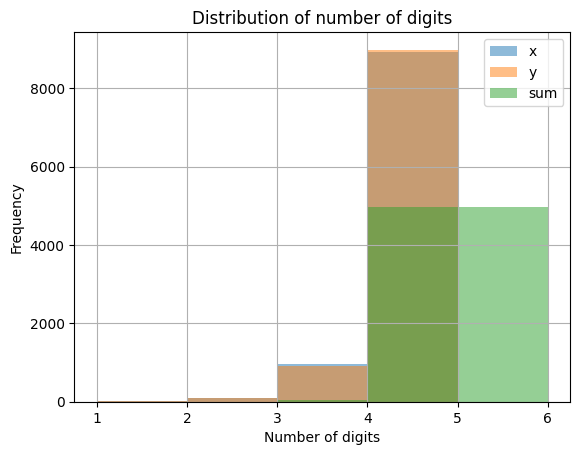

In [4]:
# Lets compute the number of digits in each number
df['x_digit'] = df['x'].apply(lambda x: len(str(x)))    
df['y_digit'] = df['y'].apply(lambda x: len(str(x)))    
df['sum_digit'] = df['sum'].apply(lambda x: len(str(x)))

# Plot the distribution of number of digits
df['x_digit'].hist(label="x",range=(1,6),bins=5,alpha=0.5)
df['y_digit'].hist(label="y",range=(1,6),bins=5,alpha=0.5)
df['sum_digit'].hist(label="sum",range=(1,6),bins=5,alpha=0.5)
plt.legend()
plt.title("Distribution of number of digits")
plt.xlabel("Number of digits")  
plt.ylabel("Frequency")
plt.show()


### Probability of the model to learn the addition with the **both number** having 1 digit, 2 digits, 3 digits, 4 digits, ...


In [6]:
print("P(both_digit=1) = ", len(df[(df["x_digit"] == 1) & (df["y_digit"] == 1)]) / num_examples * 100)
print("P(both_digit=2) = ", len(df[(df["x_digit"] == 2) & (df["y_digit"] == 2)]) / num_examples * 100)
print("P(both_digit=3) = ", len(df[(df["x_digit"] == 3) & (df["y_digit"] == 3)]) / num_examples * 100)
print("P(both_digit=4) = ", len(df[(df["x_digit"] == 4) & (df["y_digit"] == 4)]) / num_examples * 100)
print("P(both_digit=5) = ", len(df[(df["x_digit"] == 5) & (df["y_digit"] == 5)]) / num_examples * 100)


P(both_digit=1) =  0.0
P(both_digit=2) =  0.0
P(both_digit=3) =  0.7799999999999999
P(both_digit=4) =  80.15
P(both_digit=5) =  0.0


### Probability of the model to learn additions that leads to a sum with 1 digit, 2 digits, 3 digits, 4 digits, ...


In [7]:
print("P(sum_digit=1) = ", len(df[df["sum_digit"] == 1]) / num_examples* 100)
print("P(sum_digit=2) = ", len(df[df["sum_digit"] == 2]) / num_examples* 100)
print("P(sum_digit=3) = ", len(df[df["sum_digit"] == 3]) / num_examples* 100)
print("P(sum_digit=4) = ", len(df[df["sum_digit"] == 4]) / num_examples* 100)
print("P(sum_digit=5) = ", len(df[df["sum_digit"] == 5]) / num_examples* 100)


P(sum_digit=1) =  0.0
P(sum_digit=2) =  0.0
P(sum_digit=3) =  0.53
P(sum_digit=4) =  49.66
P(sum_digit=5) =  49.81


What you should do is actual oversample the existing cases!

Reference : https://arxiv.org/pdf/2308.15594 (Data Distribution affects GCD usecase)

## Example in Lagrangian example [Skip]

### Model Task:

<img src="https://i.imgur.com/dGfUOPB.png" alt="Distribtuion" width="900">


Reference: https://arxiv.org/abs/2501.09729

---

### Use Case : <br> A. Want to work with different number of fields <br> B. Want work with varying interactions <br>

We generated two datasets to look into this: 
- One with more trilinears (harder to get if randomly sample) but less large number of fields
- One randomly sampled


<img src="https://i.imgur.com/K7p8fLR.png" alt="Distribtuion" width="500">
    <p><em>Figure 1: Sampled Distribution.</em></p>
    <img src="https://i.imgur.com/s4MJA9v.png" alt="Distribtuion" width="500">
    <p><em>Figure 2: Uniform Distribution.</em></p>

### Results by nfields

<img src="https://i.imgur.com/CydNCo8.png" alt="Distribtuion" width="1000">

Reference : Train set priming https://arxiv.org/abs/2306.15400

### Results by trilinears

<img src="https://i.imgur.com/tK2izbI.png" alt="Distribtuion" width="1000">


# TAKEAWAY: What's your use case and build your data around that!
---

# **1b. Tokenization choices**
## Considerations: 
- What information is required for your model to learn?
- Do you care about expressivity? 
- Do you care about Out-of-Distribution scenarios?

## Practical 
- How much information?
- Vocabulary Size?

### Choices of Tokenization

In Language:
Example Phrase : AI For Physics
- Word-Level : AI, For, Physics
- Character-Level : A, I,  , F, o, r,  , P, h, y, s, i, c, s

In Math:
Example Expression : 100 + 420 = 520
- "Term"-level : 100, +, 420, =, 520
- "Digit"-Level : 1, 0, 0,  +,  4, 2, 0, =,  5, 2, 0

In Lagrangians:
Example Field : Higgs Particle
- Symbol Level : H
- Quantum-Numbers-Level: FIELD, SPIN, 0, SU2, 2, U1, 1



Remark: 
1. Detailed tokenization : 
- less vocabulary
- more expressive
- more token per sequence
- heavy on attention mechanism
2. Coarse tokenization : 
- more vocabulary
- less expressive
- less token per sequence
- easier on attention mechanism

### Example : Math 

In [21]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Character-level 
# 1. Generate arithmetic corpus
char_level_corpus = [" ".join(list(f"{a}+{b}={str(a + b)}")) for a in range(1000) for b in range(1000)]
vocab = {"1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9,
         "0" : 0, "+" : 10, "=" : 11,"[UNK]" : 12, "[PAD]" : 13, "[BOS]" : 14, "[EOS]" : 15}
# 2. Initialize tokenizer components
char_level_tokenizer = Tokenizer(WordLevel(vocab=vocab, unk_token="[UNK]"))
char_level_tokenizer.pre_tokenizer = Whitespace()


# Word-level 
word_level_corpus = [f"{a} + {b} = {str(a + b)}" for a in range(1000) for b in range(1000)]
word_level_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
word_level_tokenizer.pre_tokenizer = Whitespace()
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
trainer = WordLevelTrainer(special_tokens=special_tokens)
word_level_tokenizer.train_from_iterator(word_level_corpus, trainer)



lets see it in action

In [22]:
char_level_example = random.choice(char_level_corpus)
print("char_level_example : ",char_level_example)
print("char_level_tokens  : ",char_level_tokenizer.encode(char_level_example).tokens)
print("char_level_Ntokens : ",len(char_level_tokenizer.encode(char_level_example).tokens),end="\n\n")

word_level_example = random.choice(word_level_corpus)
print("word_level_example : ",word_level_example)
print("word_level_tokens  : ",word_level_tokenizer.encode(word_level_example).tokens)
print("word_level_Ntokens : ",len(word_level_tokenizer.encode(word_level_example).tokens),end="\n\n")

char_level_example :  8 5 5 + 6 7 5 = 1 5 3 0
char_level_tokens  :  ['8', '5', '5', '+', '6', '7', '5', '=', '1', '5', '3', '0']
char_level_Ntokens :  12

word_level_example :  439 + 390 = 829
word_level_tokens  :  ['439', '+', '390', '=', '829']
word_level_Ntokens :  5



Lets check vocab size

In [23]:
print("char_level_vocab_size: ",char_level_tokenizer.get_vocab_size())
print("word_level_vocab_size: ",word_level_tokenizer.get_vocab_size())

char_level_vocab_size:  16
word_level_vocab_size:  2005


Try encoding 10000

In [24]:
OOD_char_level_example =   "1 0 0 0 0"
print("char_level_tokens  : ",char_level_tokenizer.encode(OOD_char_level_example).tokens,end="\n\n")

OOD_word_level_example =   "10000"
print("word_level_tokens  : ",word_level_tokenizer.encode(OOD_word_level_example).tokens,end="\n\n")

# Something like this is possible but not intuitive (words and number are slightly different)
OOD_word_level_example =   "10 0 0 0"
print("word_level_tokens  : ",word_level_tokenizer.encode(OOD_word_level_example).tokens,end="\n\n")

char_level_tokens  :  ['1', '0', '0', '0', '0']

word_level_tokens  :  ['[UNK]']

word_level_tokens  :  ['10', '0', '0', '0']



### Example : Fields 

In [25]:
from transformers import  PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast.from_pretrained("JoseEliel/BART-Lagrangian")
sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")

example = sampled_df.sample(1)["fields"].values[0]
print("Input    = ",example)
encoded = hf_tokenizer.encode(example)
print("token_id = ", encoded)
decoded = hf_tokenizer.decode(encoded)
print("decoded  = ", decoded)


Input    =  FIELD SPIN 0 SU2 3 FIELD SPIN 1/2 SU2 2 U1 8 / 9 HEL -1/2 FIELD SPIN 0 SU3 - 3 SU2 3 U1 1 / 9
token_id =  [22, 36, 9, 37, 10, 22, 36, 5, 4, 6, 37, 6, 39, 15, 4, 16, 23, 7, 5, 4, 6, 22, 36, 9, 38, 7, 10, 37, 10, 39, 5, 4, 16]


2025-04-10 03:39:24.072660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 03:39:24.310591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 03:39:25.620747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


decoded  =  FIELD SPIN 0 SU2 3 FIELD SPIN 1 / 2 SU2 2 U1 8 / 9 HEL - 1 / 2 FIELD SPIN 0 SU3 - 3 SU2 3 U1 1 / 9


#### TAKEAWAY : THe level of tokenization affects attention usage and vocab size 
---

# Training


### NAISS : https://www.naiss.se/
- Provider of compute and storage resources
- For any researchers based in Sweden
### SUPR : https://supr.naiss.se/
- Portal to apply for it. 
- There are varyind levels of applications [small, medium, large]
- PhD students and above can already apply for small compute (Alvis: 1000GPUhs/months and Dardel: 20000 CPU-h/month!)

### Alvis : https://www.c3se.chalmers.se/about/Alvis/ <br> OnDemand Portal : https://alvis.c3se.chalmers.se/pun/sys/dashboard/

### Dardel : https://www.pdc.kth.se/

---

# Evaluation
- Generating output from the model.
- Discussion on evaluation choices:
  - Existing or novel metrics.
  - Embedding analysis.
  - Out-of-distribution tests.

## Existing Metric  : Does it work? 

mainly to see if things work as expected
Loss : Deviation from actual term 
Accuracy : How much is perfect? 
New metric, Score : (Order does not always matter, XEN)

In [ ]:
# Choose GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import lag_eval as le
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

# Load our BART-L model and tokenizer if not yet loaded
model_name = "JoseEliel/BART-Lagrangian"
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
#hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)


In [ ]:
# Load data if not already loaded, drop duplicates
#sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")
sampled_df.drop_duplicates(subset=["fields"], inplace=True)

In [ ]:
sampled_df

### Example : Lagrangian Score

Choose a random lagrangian to work with

In [ ]:
example_scenario = sampled_df.sample(1)


Look at the input (field content)

In [ ]:
example = example_scenario["fields"].values[0]
example_input = "[SOS] " + example + " [EOS]"
print("Input    = ",example_input)
encoded_input = hf_tokenizer.encode(example_input)
print("token_id = ", encoded_input)
decoded_input = hf_tokenizer.decode(encoded_input)
print("decoded  = ", decoded_input)


Look at the output (Lagrangian)

In [ ]:
example = example_scenario["Lagrangian"].values[0]
example_output = "[SOS] " + example + " [EOS]"
print("Output   = ",example_output)
encoded_output = hf_tokenizer.encode(example_output)
print("token_id = ", encoded_output)
decoded_output = hf_tokenizer.decode(encoded_output)
print("decoded  = ", decoded_output)


In [ ]:
# show the terms 
separated_terms = le.sep_terms(decoded_output)

print("First five terms: ")
for i in range(5):
    print(f"term {i} : "," ".join(separated_terms[i]))
lag_truth_1 =  " ".join([" ".join(i) for i in separated_terms])

In [ ]:
# reorder the first and second terms using list 
separated_terms[0],separated_terms[1] = separated_terms[1],separated_terms[0]

print("First five terms after reordering: ")
for i in range(5):
    print(f"term {i} : "," ".join(separated_terms[i]))

lag_truth_2 =  " ".join([" ".join(i) for i in separated_terms])


In [ ]:
print("lag_truth_1 : ",lag_truth_1)
print("lag_truth_2 : ",lag_truth_2)

In [ ]:
print("Inputs:\n", encoded_input)
print()

print("Outputs:",)
targets_1 = hf_tokenizer("[SOS] " + lag_truth_1 + " [EOS]", return_tensors="pt", truncation=True, padding=True)
targets_2 = hf_tokenizer("[SOS] " + lag_truth_2 + " [EOS]", return_tensors="pt", truncation=True, padding=True)

#print("targets_1: ", targets_1)
labels_1 = targets_1["input_ids"]
#print("targets_2: ", targets_2)
labels_2 = targets_2["input_ids"]


#print("inputs: ", hf_tokenizer.decode(encoded_input))
print("labels_1: ", labels_1)
#print("labels_1: ", hf_tokenizer.decode(labels_1[0]))
print("labels_2: ", labels_2)
#print("labels_2: ", hf_tokenizer.decode(labels_2[0]))


Generate the Lagrangians and calculate the loss

In [ ]:


with torch.no_grad():
    model.eval()
    # loss with labels_1 and labels_2
    outputs_1 = model(input_ids=torch.tensor(encoded_input).unsqueeze(0), labels=labels_1)
    print("loss with labels_1:", outputs_1.loss)
    
    # Get the prediction during training
    predicted_token_ids_1 = torch.argmax(outputs_1.logits, dim=-1)  # Shape: [batch_size, seq_len]
    predicted_string_1 = hf_tokenizer.decode(predicted_token_ids_1[0], skip_special_tokens=True)
    
    outputs_2 = model(input_ids=torch.tensor(encoded_input).unsqueeze(0), labels=labels_2)
    print("loss with labels_2:", outputs_2.loss)

    # Get the prediction during training
    predicted_token_ids_2 = torch.argmax(outputs_2.logits, dim=-1)  # Shape: [batch_size, seq_len]
    predicted_string_2 = hf_tokenizer.decode(predicted_token_ids_2[0], skip_special_tokens=True)

    # Get the prediction during inference
    generated_id     = model.generate(input_ids=torch.tensor(encoded_input).unsqueeze(0), max_length=len(labels_1[0]))
    predicted_string = hf_tokenizer.decode(generated_id[0], skip_special_tokens=True)
    

### TAKEAWAY : LOSS IS NOT ORDER/PERMUTATION INVARIANT!

Calculate the score :

<div align="center">
     <h2> S_Lagrangian = S_contraction - P_length </h2>
</div>

where:
- S_contraction = N_correct / N_true
- P_length      = N_Extra / N_true     
- S_object      = N_correct_objects / N_true


In [ ]:
lscore_1, obscore_1, conscore_1, lpen_1 = le.get_lagrangian_score(predicted_string,lag_truth_1)
lscore_2, obscore_2, conscore_2, lpen_2 = le.get_lagrangian_score(predicted_string,lag_truth_2)

print("Prediction        : ", predicted_string)
print()
print("Truth_1           : ", lag_truth_1)
print("Lagrangian score  : ",lscore_1)
print("Object score      : ",obscore_1)
print("Contraction Score : ",conscore_1)
print("Length penalty    : ",lpen_1)
print()
print("Truth_2           : ", lag_truth_2)
print("Lagrangian score  : ",lscore_2)
print("Object score      : ",obscore_2)
print("Contraction Score : ",conscore_2)
print("Length penalty    : ",lpen_2)

## Why we need model.generate() instead of model() [Skip]

In [ ]:
for p1,p2,t1,t2,p in zip(le.split_terms(predicted_string_1),le.split_terms(predicted_string_2), le.split_terms(lag_truth_1), le.split_terms(lag_truth_2),le.split_terms(predicted_string)):
    print("Predicted_1 : ",p1)
    print("Truth_1     : ",t1)
    print("--")
    print("Predicted_2 : ",p2)
    print("Truth_2     : ",t2)
    print("--")
    print("Predicted   : ",p)
    print("-----")
    print()
    print()
    

## Embedding analysis : What has it really learn?

Considerations : 
- Is efficiency the only think you need? 
- Or is it important for you to know whether the model knows what it is learning? 

Practical Questions : 
- Can it associate inputs to some embedding space? <br> 
- Can it understand relations between inputs?  <br> 

### What is embedding analysis? 


Basically information encoded in a learned vector space. 

<h4> Example in English-German translation

![Embeddings in LLM](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*52X2L01wpUjy39lIjofC7g.jpeg)

<h4> Example of food words embeddings and their corresponding possible axis

![Embeddings in LLM](https://developers.google.com/static/machine-learning/crash-course/images/embeddings_3D_tangyuan.png)

### Example : Embeddings of different field symbols

In [ ]:
sampled_df["nfields"] = sampled_df["fields"].apply(lambda x: x.count("FIELD"))
sampled_1f_scenarios_df = sampled_df[sampled_df["nfields"]==1]
sampled_1f_scenarios_df = sampled_1f_scenarios_df.sample(1000)

In [ ]:
fields      = sampled_1f_scenarios_df["fields"].apply(lambda x: set(["FIELD "+k for k in x.split("FIELD ") if k != ""])).to_list()
uniq_fields_list_1f = list(set.union(*(fields)))
uniq_fields_list_1f = [str(("[SOS] "+ k + " [EOS]").replace("  "," ")) for k in uniq_fields_list_1f]
uniq_fields_list_1f = np.unique(uniq_fields_list_1f).tolist()


In [ ]:
# Have a look at the first 10 unique fields
for i in uniq_fields_list_1f[:10]:
    print(i)

In [ ]:
from torch.utils.data import DataLoader
inputs_batch = hf_tokenizer(uniq_fields_list_1f, return_tensors='pt', truncation=True,padding=True).to(device)
data_loader  = DataLoader( torch.tensor(inputs_batch["input_ids"]).to(device), batch_size=32)

In [ ]:
from tqdm import tqdm

# Example of getting embeddings of specific cases

all_embedding_1f = []
with torch.no_grad():
    model.eval()
    for xinput in tqdm(data_loader):
        outputs = model(xinput.to(device), output_hidden_states=True)
        # Get the embeddings, which we choose to be the encoder's last hidden state of the first token
        embeddings_enc = outputs.encoder_last_hidden_state[:, 0, :].cpu().numpy()
        all_embedding_1f.append( torch.tensor(embeddings_enc))




In [ ]:
all_embedding_1f = torch.cat(all_embedding_1f, dim=0)

In [ ]:
all_embedding_1f.shape # (100, 1024) = 100 samples, 1024 dimension 

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(all_embedding_1f)



In [ ]:

def plot_3d_tsne(tsne_results, clusters_dat, with_noise=True,elev=30, azim=30,info_dict=None,cluster_order=None,title="3D Clusters of BART"):
    """
    Plots a 3D scatter plot of t-SNE results
    
    Parameters:
    - tsne_results (numpy.ndarray): The 3D coordinates from t-SNE, shape (n_samples, 3).
    - clusters_dat (numpy.ndarray): The cluster labels from DBSCAN, shape (n_samples,).
    - elev (float): Elevation angle for the 3D plot.
    - azim (float): Azimuthal angle for the 3D plot.
    """
    if cluster_order is None: cluster_order = np.unique(clusters_dat)

    colors = plt.colormaps['tab20']
    
    if info_dict is not None: cluster_colors = {cluster: colors(i) for i, cluster in enumerate(info_dict.keys())}
    else                    : cluster_colors = {cluster: colors(i) for i, cluster in enumerate(cluster_order)}

    # Create an interactive 3D scatter plot
    fig = plt.figure(figsize=(10, 5))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)

    for cluster in cluster_order:
        if not with_noise and cluster == -1: continue
        cluster_points = tsne_results[np.array(clusters_dat) == cluster]
        if info_dict is None:
            cluster_label=f'Cluster {cluster}'
        else:
            try    :cluster_label=f'{info_dict[cluster]["tag"]}'
            except :cluster_label=f'{info_dict[cluster]}'

        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
                       color=cluster_colors[cluster], label=cluster_label, alpha=0.7)

    
    ax.legend(loc='lower right', fontsize="medium", bbox_to_anchor=(.35, .65))

    # Setting labels and title
    ax.set_xlabel('TSNE Component 1',fontsize="medium")
    ax.set_ylabel('TSNE Component 2',fontsize="medium")
    ax.set_zlabel('TSNE Component 3',fontsize="medium")
    ax.tick_params(labelsize="small")    # Use ax.set_title() for a 3D plot and adjust the padding
    # Use fig.suptitle instead of ax.set_title for better control
    fig.suptitle(title, fontsize="large")  # y controls the vertical position; lower values move it closer to the plot

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # You can further lower the top value to move the plot down


In [ ]:
# In case it takes forever, load the tsne reduced embedding vectors
# with open("./tsne_results.pkl", 'rb') as f:    tsne_results = pickle.load(f)

In [ ]:
import ipywidgets as widgets

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(sampled_1f_scenarios_df["nfields"].to_numpy()), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed({1:"Embedded Vectors"}),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# in case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=sampled_1f_scenarios_df["nfields"].to_numpy(),with_noise=True, elev=30, azim=30,info_dict={1:"Embedded Vectors"},cluster_order=None,title="3D Clusters of BART")

In [ ]:
cluster_SPIN_dat_true   = ["A" if "SPIN 0" in j else "B" if ("SPIN 0" not in j and "HEL 1" not in j) else "C" if ("SPIN 0" not in j and "HEL 1" in j) else "D" for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SPIN_info_dict  = {"B":r"$\psi_L$" + " : LH Fermions","C":r"$\psi_R$" + " : RH Fermions","A":r"$\phi$" + " : Scalars" ,"D":"?" }

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SPIN_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SPIN_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SPIN_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SPIN_info_dict,cluster_order=None,title="Lorentz")

In [ ]:
cluster_SU3_dat_true  = ["3" if "SU3 3" in j else r"$\overline{3}$" if "SU3 - 3" in j    else "1" for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SU3_info_dict = {"3":"3: Triplets"     ,r"$\overline{3}$":r"$\overline{3}$" + ": Anti-Triplets"     ,"1":"1: Singlets" }

elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SU3_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SU3_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SU3_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SU3_info_dict,cluster_order=None,title="Lorentz")

In [ ]:
cluster_SU2_dat_true  = [3 if "SU2 3" in j else 2 if "SU2 2" in j    else 1 for i,j in zip(tsne_results,uniq_fields_list_1f)  ]
cluster_SU2_info_dict = {3:"3 : Triplets"     ,2:"2 : Doublets"     ,1:"1 : Singlets" }


elev_slider = widgets.FloatSlider(min=0, max=90, step=1, value=30, description='Elev')
azim_slider = widgets.FloatSlider(min=0, max=360, step=1, value=84, description='Azim')
widgets.interactive(plot_3d_tsne, 
                    tsne_results   = widgets.fixed(tsne_results), 
                    clusters_dat   = widgets.fixed(cluster_SU2_dat_true), 
                    with_noise     = widgets.fixed(True),
                    elev           = elev_slider, 
                    azim           = azim_slider,
                    info_dict      = widgets.fixed(cluster_SU2_info_dict),
                    cluster_order  = widgets.fixed(None),
                    title          = widgets.fixed("SPIN clusters")
                    )

# In case widgets are not available
# plot_3d_tsne(tsne_results, clusters_dat=cluster_SU2_dat_true,with_noise=False, elev=30, azim=30,info_dict=cluster_SU2_info_dict,cluster_order=None,title="Lorentz")

### TAKEAWAY : Embedding shows whether it had "understood" concepts

## Oout-Of-Distribution Generalization : Can it go beyond what its trained? 

Considerations : 
- Is your problem's "data space" very big? 
- Is the probably of an unseen case high? 
- If yes, then chances of OOD data cases are high. 
- Do you want to think about the next archietcture?

Practical Questions : 
- Can it work with never seen scenarios? What is your OOD?

### What are OOD?

OOD for images

![Lagrangian Example](figTeaser1.svg)

OOD for addition
- Trained on numbers up to 100 
- Test it on numbers beyond 100 

OOD for Lagrangians
- Trained on Lagrangians with 6 Fields
- Test it on Lagrangians beyond 6 Fields

### U1 Generalization

### N field Generalization

# Acknowledge SUPR
The computations and data handling were enabled by resources provided by the National Academic Infrastructure for Supercomputing in Sweden (NAISS) from projects NAISS 2025/22-521, partially funded by the Swedish Research Council through grant agreement no. 2022-06725